In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 199 kB 42.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=44c1b696e9da863a4f2fce515ff1c99890c79d241f46e4e0f085ade3ea2fff39
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


`SparkConf` : 사용자가 재정의해서 쓸 수 있는 설정 옵션들에 대한 키와 값을 갖고 있는 객체

`SparkContext` : Spark 클러스터와 연결시켜주는 객체
- Spark 모든 기능에 접근할 수 있는 시작점
- Spark는 분산환경에서 동작하기 때문에 Driver Program을 구동시키기 위해서 SparkContext가 필요
- SparkContext는 프로그램당 하나만 만들 수 있고 **사용 후에는 종료**해야함

`conf` : SparkContext를 초기화 하는데 쓰임

`setMaster("local")` : 분산된 환경이 아닌 로컬 환경을 사용

`setAppName("transformations_actions")` : 앱 이름을 transformations_actions로 설정 (Spark UI에서 확인 가능한 이름)

`sc` : sc라는 객체 생성
- *Naming Convention* : SparkContext로 만든 객체를 'sc'로 Naming 해줘야함

In [ ]:
from pyspark import SparkConf, SparkContext

# SparkContext 초기화
conf = SparkConf().setMaster("local").setAppName("transformations_actions")
# 객체 생성
sc = SparkContext(conf = conf)

---

#**1. 스파크 RDD**

##**Spark Operation = Transformations + Actions**##

####Transformations####
- 결과값으로 새로운 RDD 반환
- 지연 실행 Lazy Execution

####Actions####
- 결과값을 연산하여 출력하거나 저장
- Native Data값을 출력(List, Python Object 등)
- 즉시 실행 Eager Execution

####RDD 생성####
`parallelize` : Textfile처럼 RDD를 만드는데에 쓰임. 리스트로부터 RDD를 생성.

In [ ]:
# RDD 생성
foods = sc.parallelize(["짜장면","마라탕","짬뽕","떡볶이","쌀국수","짬뽕","짜장면","짜장면","짜장면","라면","우동","라면"])

##Actions##
- collect() : RDD 데이터를 모두 보여줌, *'값을 모두 가져올 수 있기 때문에 **디버깅이나 개발 환경에서만 사용하고 실제 프로덕트 상황에서는 지양.** 데이터를 모두 가져오기 때문에 너무 낭비가 됨'*
- countByValue() : 값의 개수를 key-value 형태로 보여줌
- take(n) : 상위 n개의 리스트를 보여줌
- first() : 첫번째 나오는 데이터 보여줌
- count() : element가 총 몇 개인지 카운팅
- foreach : 요소를 하나하나 꺼내 하나의 함수를 작용시키는데에 씀



In [ ]:
foods.first()

'짜장면'

In [ ]:
foods.count()

12

In [ ]:
# 유니크한 값 카운팅
foods.distinct().count()

7

사실 **distinct()**는 Action이 아닌 **Transformation**임. type()을 통해 확인해보자!

In [ ]:
# Native Data 타입=>Actions의 결과, int
print(type(foods.count()))
print(type(foods.distinct().count()))

# RDD타입 => Transformations의 결과
print(type(foods.distinct()))

<class 'int'>
<class 'int'>
<class 'pyspark.rdd.PipelinedRDD'>


In [ ]:
# 값 리턴을 하지 않음
# Worker node에서 실행됨
# 현재 SparkContext가 있는 Driver Program에 있기 때문에 실행 안됨
foods.foreach(lambda x:print(x))



---



##Transformations##
Transformation = Narrow + Wide



###1. Narrow Transformation###

- 1:1 변환
- 다른 열/파티션의 데이터를 쓸 필요 없음
  - 파티션 : 클러스터의 물리적 머신에 존재하는 로우의 집합. 성능에 큰 영향을 미치기 때문에 최소화 해야함
- 정렬이 필요하지 않은 경우
- 정렬 같은 경우 새로운 RDD를 만들 때 다른 열을 참고해야 함(많은 통신이 일어남), 그렇기 때문에 Narrow Transformation이 빠름
- 예시
  - filter() : 조건에 맞게 필터링
  - map() : RDD객체 반환
  - flatMap() : 1차원 RDD반환
  - sample() : 세가지 파라미터가 들어감. 밑 참조.
  - union() : 모든 값이 합쳐짐
  - subtract : 중복 데이터 사라짐


예시1

In [ ]:
# movie RDD 생성
movies =[
	"그린 북",
	"매트릭스",
	"토이 스토리",
	"캐스트 어웨이",
	"포드 V 페라리",
	"보헤미안 랩소디",
	"빽 투 더 퓨처",
	"반지의 제왕",
	"죽은 시인의 사회"
]

moviesRDD = sc.parallelize(movies)

In [ ]:
flatMovies = moviesRDD.flatMap(lambda x : x.split(" "))
flatMovies.collect()

['그린',
 '북',
 '매트릭스',
 '토이',
 '스토리',
 '캐스트',
 '어웨이',
 '포드',
 'V',
 '페라리',
 '보헤미안',
 '랩소디',
 '빽',
 '투',
 '더',
 '퓨처',
 '반지의',
 '제왕',
 '죽은',
 '시인의',
 '사회']

In [ ]:
filteredMovies = moviesRDD.filter(lambda x : x!="매트릭스")
filteredMovies.collect()

['그린 북',
 '토이 스토리',
 '캐스트 어웨이',
 '포드 V 페라리',
 '보헤미안 랩소디',
 '빽 투 더 퓨처',
 '반지의 제왕',
 '죽은 시인의 사회']

예시 2

In [ ]:
# RDD 생성
num1 = sc.parallelize([1,2,3,4,5])
num2 = sc.parallelize([4,5,6,7,8,9,10])

In [ ]:
num1.union(num2).collect()

[1, 2, 3, 4, 5, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
num1.subtract(num2).collect()

[2, 1, 3]

`sample(True, .5, seed=6)`

- True : 리샘플링 여부

- .5 : 샘플링 할 비율

- seed : seed로 샘플링한 값 고정


In [ ]:
numUnion = num1.union(num2)
numUnion.sample(True, .5, seed=2).collect()

[1, 1, 2, 4, 5, 5, 4, 5, 6, 7, 9]

예시 3 : map과 flatMap 비교

In [ ]:
# RDD 생성
rdd1 = sc.parallelize(['안녕 보아즈', 'BOAZ', '스파크', '엔지니어링 화이팅'])

print(rdd1.map(lambda x:x.split(' ')).collect())

# 1차원 반환
print(rdd1.flatMap(lambda x:x.split(' ')).collect())

[['안녕', '보아즈'], ['BOAZ'], ['스파크'], ['엔지니어링', '화이팅']]
['안녕', '보아즈', 'BOAZ', '스파크', '엔지니어링', '화이팅']


###2. Wide Transformation###
- 셔플링
- 아웃풋 파티션에 다른 파티션 데이터가 들어갈 수 있음
- 예시
  - intersection() : 겹치는 부분
  - join
  - distinct
  - reduceByKey()
  - groupByKey()
  등


In [ ]:
foodsGroup = foods.groupBy(lambda x : x[0])
res = foodsGroup.collect()

In [ ]:
for (k,v) in res:
  print(k, list(v))

짜 ['짜장면', '짜장면', '짜장면', '짜장면']
마 ['마라탕']
짬 ['짬뽕', '짬뽕']
떡 ['떡볶이']
쌀 ['쌀국수']
라 ['라면', '라면']
우 ['우동']


In [ ]:
num1.intersection(num2).collect()

[4, 5]

밑에서 다른 예제들을 더 다룰 예정

---

##**그 외 1: Reduction Operations**##

Reduction

- 요소들을 합치는 작업
- 많은 Spark 연산들이 reduction을 위함
- 대부분의 Action은 Reduction
- 대표적인 예시
  - Reduce
  - Fold
  - GroupBy
  - Aggregate

**Reduce : RDD.reduce(<function>)**

In [ ]:
from operator import add

print(sc.parallelize([1,2,3,4,5]).reduce(add))


# 파티션에 따라 결과값이 달라지기도 함

# 파티션 1개
print(sc.parallelize([1,2,3,4],1).reduce(lambda x,y : (x*2)+y))
# 파티션 2개
print(sc.parallelize([1,2,3,4],2).reduce(lambda x,y : (x*2)+y))

15
26
18


**Fold : RDD.fold(zeroValue, \<function>)**

- Reduce와 다른 점은 `zeroValue`가 들어간다는 것

- `zeroValue` : 각 파티션의 시작값


In [ ]:
# 파티션이 4개인 RDD -> 값이 3가지라 하나의 빈 파티션이 발생
rdd = sc.parallelize([2,3,4],4)

# 24 = 2*3*4
print(rdd.reduce(lambda x,y : x*y))

# zeroValue값이 0
# 0 = 0*2*3*4
print(rdd.fold(0, lambda x,y : x*y))

# 24 = 1*2*3*4
print(rdd.fold(1, lambda x,y:x*y))

24
0
24


**GroupBy : RDD.groupBy(<기준함수>)**

- 그룹핑을 해주는 Reduction Action

In [ ]:
rdd = sc.parallelize([1,1,2,3,5,8])
result = rdd.groupBy(lambda x : x%2).collect()

# 결과
sorted([(x, sorted(y)) for (x,y) in result])

[(0, [2, 8]), (1, [1, 1, 3, 5])]

**Aggregate : RDD.aggregate(zeroValue, seqOp, combOp)**

- zeroValue : 각 파티션에 누적할 시작 값
- seqOp : 타입 변경 함수(map이라고 생각해도됨)
- combOp : 합치는 함수(reduction을 한다는 느낌)
- 파티션 단위의 연산 결과를 합치는 과정을 거침

In [ ]:
seqOp = (lambda x,y:(x[0] + y, x[1] + 1))
combOp = (lambda x,y:(x[0] + y[0], x[1] + y[1]))
sc.parallelize([1,2,3,4]).aggregate((0,0), seqOp, combOp)

(10, 4)

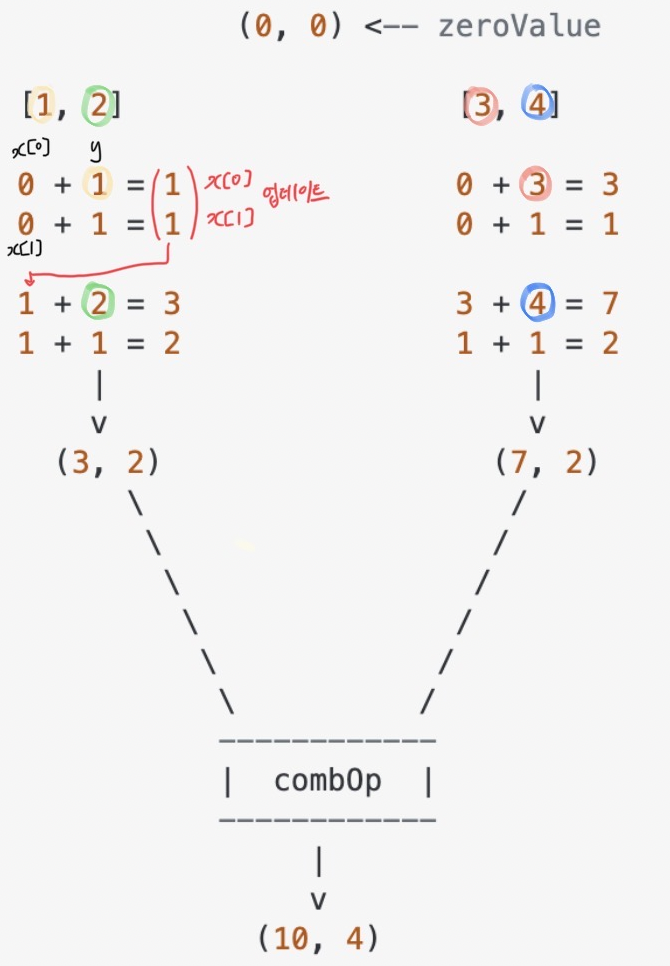

##**그 외 2: Key-Value RDD Operations & Joins**##

###Key-Value RDD Transofmrations & Actions###

- Transformations
  - groupByKey
  - reduceByKey
  - mapValues
  - keys
  - join(+leftOuterJoin, rightOuterJoin)
- Actions
  - countByKey



*Key-Value RDD에서 대부분의 변형이 transformation인데 그 이유는 처리 결과값이 크기 때문*

**groupByKey : 주어진 Key를 기준으로 그룹핑**
- groupBy와는 다름

In [ ]:
x = sc.parallelize([("MATH",7),("MATH",),("ENGLISH",7),("SCIENCE",7),("ENGLISH",4),("ENGLISH",9),
("MATH",8),("MATH",3),("ENGLISH",4),("SCIENCE",6),("SCIENCE",9),("SCIENCE",5)], 3)

y = x.groupByKey()

print(y.getNumPartitions())

3


In [ ]:
y = x.groupByKey(2)
print(y.getNumPartitions())

2


**reduceByKey : Key를 기준으로 그룹을 만들고 합침**
- reduce와 다름
- <U>개념적으로는 groupByKey + reduction</U> *하지만*, groupByKey보다 훨씬 빠름


In [ ]:
from operator import add, mul


rdd = sc.parallelize([("BOAZ",2),("ENGINEERING",3),("BOAZ",5)])
print(sorted(rdd.reduceByKey(add).collect()))
print(sorted(rdd.reduceByKey(mul).collect()))

[('BOAZ', 7), ('ENGINEERING', 3)]
[('BOAZ', 10), ('ENGINEERING', 3)]


**mapValues : 함수를 Value에게만 적용한다**
- 장점 : Partition과 Key를 왔다갔다하면 network cost가 커지지만 함수를 value에게만 적용하기에 network cost가 작아짐
- Partition과 Key는 그대로

In [ ]:
x = sc.parallelize([("a", ["HELLO","BOAZ","WELCOME"]), ("b", ["ENGINEERING"])])

def f(x) : return len(x)

# 리스트의 길이 리턴
x.mapValues(f).collect()

[('a', 3), ('b', 1)]

**countByKey : 각 Key가 가진 요소들을 셈**

In [ ]:
x = sc.parallelize([("MEOW", 1), ("BOWWOW", 1), ("MEOW",1)])
sorted(x.countByKey().items())

[('BOWWOW', 1), ('MEOW', 2)]

**keys**
- 모든 Key를 가진 RDD 생성 (Transformation임)

In [ ]:
# 예제 1
m = sc.parallelize([(1,2),(3,4)]).keys()
m.collect()

[1, 3]

In [ ]:
# 예제 2
x = sc.parallelize([("MATH",7),("MATH",2),("ENGLISH",7),("SCIENCE",7),("ENGLISH",4),("ENGLISH",9),("MATH",8),("MATH",3),("ENGLISH",4),("SCIENCE",6),("SCIENCE",9),("SCIENCE",5)], 3)
x.keys().distinct().count()

3

**Joins**
- Transformation
- 여러개의 RDD를 합치는데 사용
- 대표적으로 두가지 방식이 존재
  - Inner Join(join) : 서로 연관된 데이터만 가져옴(교집합)
  - Outer Join(left outer, right outer, full outer) : 한쪽에는 데이터가 있고 다른쪽에 없는 경우, 데이터가 있는 쪽의 데이터를 출력

In [ ]:
rdd1 = sc.parallelize([("fish",1), ("kitten", 2), ("puppy", 3)])
rdd2 = sc.parallelize([("fish",4), ("kitten", 5), ("kitten", 6), ("pet", 1)])

print(rdd1.join(rdd2).collect())
print(rdd1.leftOuterJoin(rdd2).collect())
print(rdd1.rightOuterJoin(rdd2).collect())

[('fish', (1, 4)), ('kitten', (2, 5)), ('kitten', (2, 6))]
[('fish', (1, 4)), ('puppy', (3, None)), ('kitten', (2, 5)), ('kitten', (2, 6))]
[('fish', (1, 4)), ('kitten', (2, 5)), ('kitten', (2, 6)), ('pet', (None, 1))]


In [ ]:
# 사용 후 종료!

sc.stop()